In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
path = os.path.join("hawaii.sqlite")

In [5]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{path}")

In [6]:
engine.execute("SELECT * FROM station")

In [7]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()

In [8]:
# reflect the tables
Base.prepare(engine, reflect=True)


In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
data = engine.execute("SELECT * FROM measurement")
latest_date = session.query(func.max(measurement.date)).first()
print(latest_date)

('2017-08-23',)


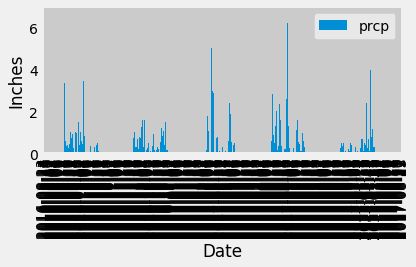

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

last_year_date=dt.date(2017, 8, 23) - dt.timedelta(days=366)
#print('Query Date:', last_year_date)

# Perform a query to retrieve the data[sic date] and precipitation scores
#prcp_scores=session.query(Measurement.date).filter(Measurement.date).filter(Measurement.prcp).group_by(Measurement.date).order_by(Measurement.date).all()
prcp_scores=session.query(measurement.date,func.max(measurement.prcp))\
    .filter(func.strftime('%Y-%m-%d',measurement.date) > last_year_date)\
    .group_by(measurement.date).all()
#prcp_scores=engine.execute('SELECT * FROM Measurement Where date BETWEEN 2016-08-22 AND 2017-08-23').fetchall()
#print(prcp_scores)

# Save the query results as a Pandas DataFrame and set the index to the date column
#prcp_scores=pd.read_sql('SELECT * FROM prcp_scores'), con=engine

prcp_scores_df = pd.DataFrame(prcp_scores, columns=['date', 'prcp'])
#prcp_scores_df=pd.read_sql("SELECT * FROM prcp_scores"), con=engine

# Sort the dataframe by date
prcp_scores_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

prcp_scores_df.plot.bar()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.show()



In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_scores_df.describe

<bound method NDFrame.describe of             prcp
date            
2016-08-23  1.79
2016-08-24  2.28
2016-08-25  0.21
2016-08-26  0.04
2016-08-27  0.18
...          ...
2017-08-19  0.09
2017-08-20  0.01
2017-08-21  0.56
2017-08-22  0.50
2017-08-23  0.45

[366 rows x 1 columns]>

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(station.station)).all()
total_stations

[(9)]

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_count = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_count


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#The station with the highest count is staion USC00519281
station = [measurement.station,
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)]

active_station = session.query(*station).filter(measurement.station == "USC00519281").all()
active_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

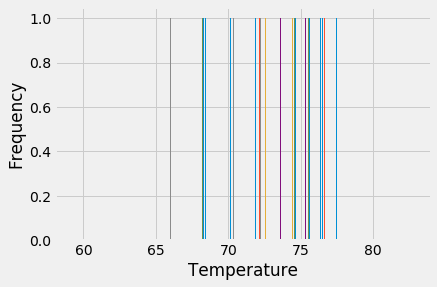

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_tobs = session.query(measurement.tobs).filter(measurement.station == "USC00519281")\
    .filter(measurement.date >= last_year_date).all()
year_tobs_df = pd.DataFrame(year_tobs, columns=['measurement.tobs'])
#year_tobs_.plot.hst(by=year_tobs, bins=12)
#fig, ax = plt.subplots()
#x = range(len(year_tobs))
#ax.hist(year_tobs)
#ax.set_title('tobs')
#fig.tight_layout()
#plt.show()
plt.hist(year_tobs_df, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [19]:
# Close Session
session.close()

Step 2 Climate App

In [20]:
# Import Flask
from flask import Flask, jsonify

#Create an app
app = Flask(__name__)

In [21]:
#Define route
#Home page
@app.route("/")
def home():
    return "Home page"
#List all routes available



In [22]:
#Convert the query results to a dictionary using date as the key and prcp as the value.


#Return the JSON representation of your dictionary.
@app.route("/api/v1.0/precipitation")
def prcp_scores():
    return jsonify(prcp_scores)


In [25]:
#Return a JSON list of stations from the dataset
@app.route("/api/v1.0/stations")
def station_count():
    return jsonify(station_count)

In [26]:
#Query the dates and temperature observations of the most active station for the last year of data
#Return a JSON list of temperature observations (TOBS) for the previous year.
@app.route("/api/v1.0/tobs")
def year_tobs():
    return jsonify(year_tobs)

In [33]:
#Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range
#When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
@app.route("/api/v1.0/<start>")
def active_station():
    return jsonify(active_station)

#When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive
@app.route("/api/v1.0/<start>/<end>")
def station():
    return jsonify(station)

AssertionError: View function mapping is overwriting an existing endpoint function: active_station

In [34]:
if __name__ =="__main__":
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: 1

/Users/serenabaker/opt/anaconda3/envs/pythondata/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
